In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np

from IPython.core.display import display, HTML
from IPython.display import Markdown as md

from matplotlib.ticker import EngFormatter

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def myround(x, base=5):
    return base * round(x/base)

# Estilo verde-rojito
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val > 0 else 'black'
    if val < 0: color = 'green'
    return 'color: %s' % color

# Estilo gris
def color_gray(val):
    color = '.5'
    return 'color: %s' % color


In [3]:
display(HTML("<style>.rendered_html {font-size: 16px; line-height: 1.8; text-indent: 2rem}</style>"))
# display(HTML("<style>.rendered_html {  }</style>"))

In [4]:
frac = 0.02

In [5]:
yrs_pob_data = 4

In [6]:
aglo_labels = pd.read_csv('./../data/info/aglo_labels.csv')[['AGLOMERADO', 'NOMAGLO']]

radio_ref = pd.read_csv('./../data/info/radio_ref.csv')
# radio_ref[['PROV','NOMPROV','DPTO', 'NOMDPTO']].drop_duplicates().to_csv('./data/DPTO_PROV.csv', index = False)
dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
radio_ref = radio_ref.merge(dpto_region)
radio_ref = radio_ref[['RADIO_REF_ID', 'NOMDPTO','NOMPROV', 'AGLOMERADO', 'Region']].drop_duplicates().merge(aglo_labels)


data = pd.read_csv('./../data/Pobreza/pobreza_'+str(frac)+'_2019.csv')

data['Grupo Etario'] = pd.cut(data.P03, np.arange(-1, 80, 3))#.round(-1) ## Customizar grupo etario

data = data.merge(radio_ref, on = ['RADIO_REF_ID', 'AGLOMERADO'])
data['AGLO_si'] = data.AGLOMERADO != 0

pob_tot = len(data)/frac/yrs_pob_data
pob_tot

44165600.0

# Ingresos de hogares, pobreza e indigencia. (Argentina)

Matias Iglesias

matuteiglesias@gmail.com


# Introducción. 

Este reporte presenta estimaciones de ingreso medio de hogares y personas en todo el territorio de la Republica Argentina a partir de la información en la Encuesta Permanente de Hogares (EPH) y el Censo de Población, Hogares y Viviendas de 2010, realizados por el Instituto Nacional de Estadística y Censos (INDEC).

Explotando las variables en común contenidas en ambas fuentes se entrenan algoritmos de clasificación y regresión que predicen los ingresos de muestras sintéticas de la población total consultada en Censo. O sea *machine learning* aplicado al Censo y las encuestas de hogares. Esto permite obtener valores de ingresos, incidencia de pobreza e indigencia y otras variables socioeconómicas segun características demográficas y habitacionales de las provincias, areas metropolitanas, departamentos, partidos, comunas u otras areas censales detalladas.

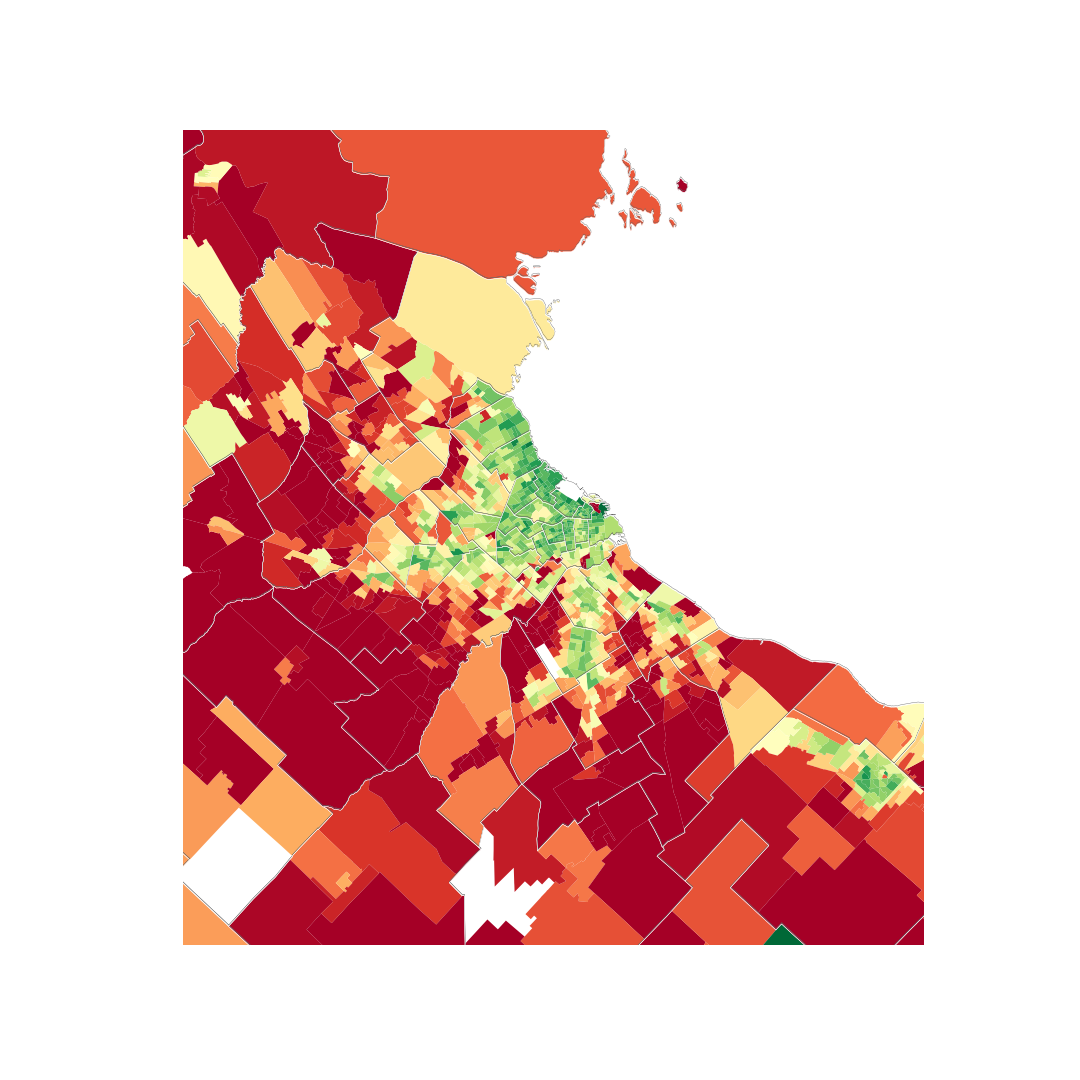

In [7]:
from IPython.display import Image
Image("./mapa_portada.png")

# Contenido
- Incidencia de pobreza e indigencia
- Evolucion semestral

    - Cantidades (miles)
    - Porcentajes

- Ingresos a precios constantes (ARS 2019Q2)
    - Deciles de ingreso
    - Lineas de Pobreza e indigencia

- Dependencia con otras variables
    - Habitaciones de la vivienda
    - Edad
    - Niveles educativos

- Dependencia geografica
    - Variacion regional
    - Por departamento y fraccion censal
    - Por Provincia
    - Por Region y aglomerado
    - Partidos y Comunas del AMBA
    
- Evolucion temporal por areas especificas.

- Lista de Aglomerados

# Incidencia de pobreza e indigencia
## Total Pais

In [8]:
# df = pd.read_csv('./../data/cuadros/cuadro_'+str(frac)+'_Total_pais_Q_n_ARG', index_col=[0, 1], header = [0, 1]).drop_duplicates().unstack(0, 1)
# df.index = pd.to_datetime(df.index)

# df_ = df[['Indigencia', 'Pobreza']].groupby(pd.Grouper(level = 0, freq = '6MS')).mean().T
# n = df_.copy()
# n.columns = n.columns.to_period("6M")

# df = pd.read_csv('./../data/cuadros/cuadro_'+str(frac)+'_Total_pais_Q_pct_ARG', index_col=[0, 1], header = [0, 1]).drop_duplicates().unstack(0, 1)
# df.index = pd.to_datetime(df.index)

# df_ = df[['Indigencia', 'Pobreza']].groupby(pd.Grouper(level = 0, freq = '6MS')).mean().T
# pct = df_.copy()
# pct.columns = pct.columns.to_period("6M")


# total_pais = pd.concat([pd.DataFrame(n.iloc[:, -1]),
#                         pd.DataFrame(pct.iloc[:, -1])], axis = 1)
# total_pais.columns = ['Cantidad (miles)', 'Porcentaje']

# x = total_pais
# x.index = x.index.droplevel(2)

cuadro5 = pd.read_csv('./../data/cuadros/cuadro4_'+str(frac)+'_ARG', index_col=[0, 1], header = [0, 1, 2])
df = cuadro5.iloc[:, cuadro5.columns.get_level_values(0).isin(['Indigencia', 'Pobreza'])
            & cuadro5.columns.get_level_values(2).isin(['Hogares', 'Personas'])]

# Leave just time as index
df = df.unstack()

df.index = pd.DatetimeIndex(df.index)

# Ultimo periodo
x = df.iloc[-1].unstack([3, 1])
x.columns = ['Porcentaje', 'Cantidad (miles)']

# Rolling 4 trimestres de interpolado
df = df.resample('Q').mean().interpolate().rolling(4).mean()

x.round({'Cantidad (miles)': -2, 'Porcentaje': 1}).sort_index()

Porcentaje  Cantidad (miles)
Indigencia Hogares         10.3            1400.0
           Personas        13.8            6200.0
Pobreza    Hogares         37.2            5000.0
           Personas        47.7           21300.0

In [9]:

md("En el primer trimestre de 2019, la pobreza alcanza el {:.0f}".format(x.loc[('Pobreza', 'Hogares')].Porcentaje)+"% \
   de los hogares, donde viven el {:.0f}".format(x.loc[('Pobreza', 'Personas')].Porcentaje)+"% de las personas ({:.1f}".format(0.001*x.loc[('Pobreza', 'Personas')]['Cantidad (miles)'])+" millones). \
   La indigencia en el mismo periodo alcanza al {:.1f}".format(x.loc[('Indigencia', 'Hogares')].Porcentaje)+"% de los hogares, en donde viven {:.1f}".format(0.001*x.loc[('Indigencia', 'Personas')]['Cantidad (miles)'])+" millones de\
   personas ({:.1f}".format(x.loc[('Indigencia', 'Personas')].Porcentaje)+"%)")
     

En el primer trimestre de 2019, la pobreza alcanza el 37%    de los hogares, donde viven el 48% de las personas (21.3 millones).    La indigencia en el mismo periodo alcanza al 10.3% de los hogares, en donde viven 6.2 millones de   personas (13.8%)

## Evolucion Temporal

(0.0, 70.0)

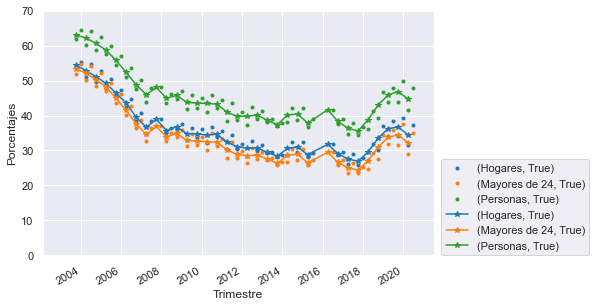

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette("tab10")
sns.set()

df = cuadro5['Pobreza']['mean'].unstack()
# df = cuadro5['Indigencia']['mean'].unstack()
df.index = pd.to_datetime(df.index) #- pd.offsets.DateOffset(10)

fig, ax = plt.subplots(1, figsize = (7, 5))

df.plot(lw = 0, marker = '.', ax = ax, color = pal.as_hex()[:6])

# df.groupby(pd.Grouper(level = 0, freq='6M')).mean().plot(ax = ax, color = pal.as_hex()[:6])

years = df.index.year.astype(int)
semes = (df.index.month.astype(int) - 1) // 6
grouped = df.groupby([years, semes])
mn = grouped.mean();
idx = mn.index.get_level_values(0).astype(str) +  (1 + 6 * mn.index.get_level_values(1)).astype(str)
idx = pd.to_datetime(idx, format='%Y%m') + pd.offsets.DateOffset(months=3)
mn.index = idx

mn.plot(marker = '*', ax = ax, color = pal.as_hex()[:6])

ax.legend(loc = (1.02,0))
ax.set_ylabel('Porcentajes')
ax.set_xlabel('Trimestre')
# ax.legend(['Pobreza, personas', 'Pobreza, hogares', 
#            'Indigencia, personas', 'Indigencia, hogares'])
ax.set_xlim(pd.Timestamp('2002-02-15'), pd.Timestamp('2021-07-01'))
ax.set_ylim(0, 70)

plt.ylim(0, )

In [40]:
# sns.set()

# fig, ax = plt.subplots(1, figsize = (10, 7))

# # Series
# df_ = df.iloc[:, df.columns.get_level_values(1) == 'mean']
# df_ = df_.T.reindex(df_.T.sum(1).sort_values(ascending = False).index).T
# df_.columns = df_.columns.droplevel([1, 3])
# df_.plot(ax = ax, marker = '.')


# # df_2 = cuadro3.iloc[:, cuadro3.columns.get_level_values(0).isin(['Indigencia', 'Pobreza'])
# #             & cuadro5.columns.get_level_values(2).isin(['Hogares', 'Personas']) & (cuadro5.columns.get_level_values(1) == 'mean')]
# # df_2 = df_2.loc[df_2.index.get_level_values(1) == True]
# # # Leave just time as index
# # df_2 = df_2.unstack()
# # df_2.index = pd.DatetimeIndex(df_2.index)
# # df_2.columns = df_2.columns.droplevel([1, 3])
# # # Rolling 4 trimestres de interpolado
# # df_2 = df_2.resample('Q').mean().interpolate().rolling(4).mean()
# # df_2.plot(ax = ax, marker = '.')

# # Plot
# ax.legend(loc = (1.02,0))
# ax.set_ylabel('Porcentajes')
# ax.set_ylim(0, 70)
# plt.setp(ax.xaxis.get_majorticklabels(), rotation = 30, ha="left" )
# ax.set_xlim(pd.Timestamp('2002-02-15'), pd.Timestamp('2019-07-01'))
# ax.set_xlabel('Trimestre')
# ax.legend(['Pobreza, personas', 'Pobreza, hogares', 
#            'Indigencia, personas', 'Indigencia, hogares'])

# # # ANADIR SERIE CEDLAS
# # serie_cedlas = pd.read_csv('./../data/info/tornarolli_cedlas.csv', index_col=[0, 1], header = [0, 1])
# # serie_cedlas = serie_cedlas.T[serie_cedlas.columns.get_level_values(1) == 'Comparable'].T
# # serie_cedlas.columns = serie_cedlas.columns.get_level_values(0)
# # serie_cedlas.index = pd.date_range("2003-09", periods=len(serie_cedlas), freq = '6M')
# # (1.*serie_cedlas).plot(color = '.6', marker = '+', ax = ax)

# plt.show()

Los puntos de este gráfico son los **valores promedios de los últimos 4 trimestres**. Previo a ese cálculo se interpola linealmente para tener los valores de los trimestres 2007-Q3, 2015-Q3, 2015-Q4, y 2016-Q1 para los cuales el INDEC no ofrece bases de microdatos.

En los últimos 15 años hay una tendencia de **descenso** de los niveles de pobreza.

***El dilema de 'Los numeros del INDEC'***

Existe un cuestionamiento de las series de índice de precios ofrecidas por INDEC entre 2007 y 2015. Los cálculos de los niveles de pobreza dependen de los valores en términos reales de las canastas alimentarias.

En este trabajo:
   * Se usan las canastas alimentaria y total regionales establecidas por INDEC desde 2016.
   * Construimos un indice de precios mensual de consenso entre las multiples mediciones disponibles en cada periodo.
   * El valor medio de las canastas de INDEC post 2016, a precios constantes se usa para los años anteriores.
   
De esta forma tenemos una regla fija para los niveles de pobreza en todo el período, **independiente de los índices de precios elaborados por INDEC**.

## Separacion 'aglomerados' vs resto del pais

In [41]:
#md("Los indicadores mas usados en determinar incidencia de pobreza se restringen a los llamados áglomerados urbanos'. La cifra de {:.0f}".format(x.loc[('Pobreza', 'Personas')].Porcentaje)+"% de las personas en pobreza difiere del 32.0% reportado por INDEC para el segundo semestre de 2018 los 33,6% reportados en el informe de UCA para 2018-Q3, principalmente por incluir la poblacion que vive fuera de los aglomerados urbanos.")

***La Encuesta de Hogares no releva zonas rurales***

El INDEC publica en informes semestrales los principales indicadores de pobreza e indigencia. La fuente primaria de información para ellos es la encuesta de hogares EPH. Sin embargo, esta última releva sólamente aglomerados urbanos grandes, dejando en un punto ciego al casi 9% de la poblacion que vive en zona rural, ademas de otro 25% de las personas y hogares que no pertenecen a los aglomerados grandes. 

### Porcentajes
#### Niveles

In [42]:
# df = pd.read_csv('./../data/cuadros/cuadro_'+str(frac)+'_AGLO_si_Q_pct_ARG', index_col=[0, 1], header = [0, 1]).drop_duplicates().unstack(0, 1)
# df.index = pd.to_datetime(df.index)

# df_ = df[['Indigencia', 'Pobreza']].groupby(pd.Grouper(level = 0, freq = '6MS')).mean().T
# df_.index = pd.MultiIndex.from_tuples([(x[0], x[1], 'Aglomerados' if x[2] else 'Resto') for x in df_.index])
# show = df_.copy()
# show.columns = show.columns.to_period("6M")
# show = show.interpolate(axis = 1)

# show.round(1).style.set_properties(**{'color': 'gray'}, subset=[show.columns[3]])


# # error relativo 0.01

In [14]:
cuadro3 = pd.read_csv('./../data/cuadros/cuadro2_'+str(frac)+'_ARG', index_col=[0, 1], header = [0, 1, 2])
df = cuadro3.iloc[:, cuadro5.columns.get_level_values(0).isin(['Indigencia', 'Pobreza'])
            & cuadro5.columns.get_level_values(2).isin(['Hogares', 'Personas'])
                 & cuadro5.columns.get_level_values(1).isin(['mean'])]

# Leave just time as index
df = df.unstack()

df.index = pd.DatetimeIndex(df.index)

# Ultimo periodo
x = df.iloc[-1].unstack([3, 1])
x.columns = ['Fuera de aglomerados', 'Aglomerados']

x.round(1)

Fuera de aglomerados  Aglomerados
Indigencia Hogares                   12.9          8.8
           Personas                  17.5         11.7
Pobreza    Hogares                   43.1         33.8
           Personas                  54.6         43.7

***Posible sobreestimacion de pobreza rural***

A la espera de una mejor solución (es decir, que se implemente un muestreo directo de la poblacion fuera de aglomerados), asumimos que ésta es equivalente a la relevada en los centros urbanos. Ciertamente esto puede conllevar a errores sistemáticos. por dar un ejemplo, el nivel educativo en las zonas rurales es significativamente menor. En la ciudad este es un signo de peores condiciones de trabajo e ingresos, pero no necesariamente esto es así en un entorno rural. 

Si nos basamos en niveles educativos podríamos facilmente sobreestimar la pobreza rural, y por lo tanto el total nacional. 
Al presentar los resultados desagregados geograficamente este tema puede salvarse.

In [15]:
startyr = 2003
endyr = 2021


***Serie Temporal***


In [16]:
# Rolling 4 trimestres de interpolado
df = df.resample('Q').mean().interpolate()

show = df.groupby(pd.Grouper(level = 0, freq = 'Y')).mean()
show.columns = show.columns.droplevel(1)
show.index = range(startyr, endyr)

show.columns = pd.MultiIndex.from_tuples([(x[0], x[1], 'Aglomerados' if x[2] else 'Resto') for x in show.columns])

show.T.round(1)

2003  2004  2005  2006  2007  2008  2009  \
Indigencia Hogares  Resto        29.9  27.1  24.5  19.9  16.6  15.8  14.9   
                    Aglomerados  19.0  17.5  15.1  12.0   9.9   9.2   8.8   
           Personas Resto        38.7  35.5  32.2  26.4  22.5  21.4  20.4   
                    Aglomerados  25.0  23.4  20.3  16.0  13.5  12.4  11.7   
Pobreza    Hogares  Resto        64.2  61.1  56.8  49.8  45.9  44.3  42.6   
                    Aglomerados  48.9  46.8  42.7  36.9  33.1  31.7  30.4   
           Personas Resto        72.3  70.1  66.0  59.1  55.5  53.9  52.7   
                    Aglomerados  57.6  56.3  52.0  45.5  42.0  40.3  38.4   

                                 2010  2011  2012  2013  2014  2015  2016  \
Indigencia Hogares  Resto        13.9  12.4  11.9  10.9  11.4  10.9  11.5   
                    Aglomerados   8.0   7.4   7.4   6.6   7.3   6.8   7.4   
           Personas Resto        19.0  16.8  16.3  14.9  15.4  14.8  15.6   
                    Aglomerados  10.7   9.8   9.8   9.0   9.5   9.0   9.8   
Pobreza    Hogares  Resto        42.4  38.7  37.2  35.3  36.7  35.3  36.2   
                    Aglomerados  30.2  27.8  27.0  25.3  27.5  26.3  26.9   
           Personas Resto        52.3  48.5  47.6  45.4  47.4  45.9  47.1   
                    Aglomerados  38.2  35.6  35.5  33.7  36.1  34.8  35.6   

                                 2017  2018  2019  2020  
Indigencia Hogares  Resto        10.0  11.2  13.5  12.2  
                    Aglomerados   6.2   7.3   9.0   8.2  
           Personas Resto        13.6  15.5  18.4  16.7  
                    Aglomerados   8.2   9.7  12.0  11.0  
Pobreza    Hogares  Resto        32.9  37.5  42.9  40.4  
                    Aglomerados  24.0  28.2  32.8  30.9  
           Personas Resto        42.9  47.9  53.7  51.9  
                    Aglomerados  31.9  36.7  42.0  40.4

In [17]:
show = df.diff(4).groupby(pd.Grouper(level = 0, freq = 'Y')).mean()
show.columns = show.columns.droplevel(1)
show.index = range(startyr, endyr)
show.columns = pd.MultiIndex.from_tuples([(x[0], x[1], 'Aglomerados' if x[2] else 'Resto') for x in show.columns])

show.T.round(2).style.applymap(color_negative_red).format("{:.2f}")

El ultimo minimo para todas las series de pobreza e indigencia se da en el segundo semestre de 2017.

### Cantidades (miles)
### Niveles

In [18]:
# # Escala crecimiento poblacional para cantidades... No se usa mas porque ahora los archivos ya vienen escalados

# escala = pd.read_csv('./../data/info/escala_poblacion.csv')
# escala.index = pd.DatetimeIndex(pd.date_range(start = '2010', freq='Y', periods = len(escala))+ pd.DateOffset(days=-184) )
# escala = escala[['r2018']].resample('6M').interpolate().loc['2014':'2018']

In [19]:
# md("En el tercer trimestre de 2018, la pobreza alcanza {:.1f}".format(0.001*x.loc[('Pobreza', 'Personas')]['Cantidad (miles)'])+" millones de personas en todo el pais. \
#    \n\
#    La indigencia en el mismo periodo alcanza {:.1f}".format(0.001*x.loc[('Indigencia', 'Personas')]['Cantidad (miles)'])+" millones de personas\
#    \n\
#    A continuación la desagregacion entre aglomerados y resto del país. ")

In [20]:
# df = pd.read_csv('./../data/cuadros/cuadro_'+str(frac)+'_AGLO_si_Q_n_ARG', index_col=[0, 1], header = [0, 1]).drop_duplicates().unstack(0, 1)
# df.index = pd.to_datetime(df.index)

# df_ = df[['Indigencia', 'Pobreza']].groupby(pd.Grouper(level = 0, freq = '6MS')).mean().T
# df_.index = pd.MultiIndex.from_tuples([(x[0], x[1], 'Aglomerados' if x[2] else 'Resto') for x in df_.index])
# show = df_.copy()
# show = (show.T*escala.values).T
# show.columns = show.columns.to_period("6M")
# show = show.interpolate(axis = 1)

# myround(show, 20).style.set_properties(**{'color': 'gray'}, subset=[show.columns[3]])


# # Redondear en decenas de miles? al menos..



In [21]:
cuadro3 = pd.read_csv('./../data/cuadros/cuadro2_'+str(frac)+'_ARG', index_col=[0, 1], header = [0, 1, 2])
df = cuadro3.iloc[:, cuadro5.columns.get_level_values(0).isin(['Indigencia', 'Pobreza'])
            & cuadro5.columns.get_level_values(2).isin(['Hogares', 'Personas'])
                 & cuadro5.columns.get_level_values(1).isin(['sum'])]

# Leave just time as index
df = df.unstack()

df.index = pd.DatetimeIndex(df.index)

# Ultimo periodo
x = df.iloc[-1].unstack([3, 1])
x.columns = ['Fuera de aglomerados', 'Aglomerados']

myround(x, 20).astype(int)
# Error es 10mil en pobreza hogares, 50mil en pobreza personas


Fuera de aglomerados  Aglomerados
Indigencia Hogares                    640          760
           Personas                  2880         3280
Pobreza    Hogares                   2100         2920
           Personas                  9000        12280

***Serie Temporal***

In [22]:
# Rolling 4 trimestres de interpolado
df = df.resample('Q').mean().interpolate()

show = df.groupby(pd.Grouper(level = 0, freq = 'Y')).mean()
show.columns = show.columns.droplevel(1)
show.index = range(startyr, endyr)

myround(show.T, 20).astype(int)

2003   2004   2005   2006   2007  2008  2009  \
                    AGLO_si                                                  
Indigencia Hogares  False     1200   1100   1020    840    700   680   640   
                    True      1360   1260   1100    900    740   700   680   
           Personas False     5280   4920   4520   3740   3220  3120  2960   
                    True      5760   5460   4800   3860   3280  3060  2940   
Pobreza    Hogares  False     2600   2500   2340   2080   1940  1900  1840   
                    True      3500   3380   3140   2740   2500  2420  2340   
           Personas False     9880   9680   9280   8360   7940  7840  7660   
                    True     13280  13100  12260  10920  10200  9920  9620   

                             2010  2011  2012  2013  2014  2015  2016  2017  \
                    AGLO_si                                                   
Indigencia Hogares  False     600   540   540   500   520   500   540   480   
                    True      620   580   580   540   600   560   620   520   
           Personas False    2780  2540  2460  2280  2400  2320  2480  2180   
                    True     2720  2520  2560  2360  2520  2420  2660  2260   
Pobreza    Hogares  False    1860  1720  1660  1600  1680  1640  1700  1560   
                    True     2360  2200  2160  2040  2240  2160  2240  2020   
           Personas False    7680  7300  7200  6960  7340  7220  7480  6860   
                    True     9660  9100  9200  8840  9560  9300  9620  8740   

                              2018   2019   2020  
                    AGLO_si                       
Indigencia Hogares  False      540    660    600  
                    True       620    760    700  
           Personas False     2520   3020   2760  
                    True      2660   3340   3100  
Pobreza    Hogares  False     1800   2080   1980  
                    True      2380   2800   2660  
           Personas False     7780   8820   8540  
                    True     10100  11680  11360

In [23]:
show = df.diff(4).groupby(pd.Grouper(level = 0, freq = 'Y')).mean()
show.columns = show.columns.droplevel(1)
show.index = range(startyr, endyr)

show.T.round(-1).style.applymap(color_negative_red).format("{:.0f}")

In [24]:
nuevos_pobres = show.iloc[-4:]['Pobreza']['Personas'].sum().sum()
nuevos_indigs = show.iloc[-4:]['Indigencia']['Personas'].sum().sum()

md("Las estimaciones dan cuenta que en 2019 habrá {:.1f}".format(0.001*nuevos_pobres)+" millones de pobres más que en 2015. \
   Además habrá {:.1f}".format(0.001*nuevos_indigs)+" millones de nuevos indigentes. Los niveles de pobreza en 2019 igualan a los de 2008.")

Las estimaciones dan cuenta que en 2019 habrá 3.0 millones de pobres más que en 2015.    Además habrá 0.9 millones de nuevos indigentes. Los niveles de pobreza en 2019 igualan a los de 2008.

## Ingresos a precios constantes (ARS 2019-Q4)

Los valores monetarios reportados son en todos los casos en pesos argentinos (AR$) a valores constantes de 2019-Q4.

### Percentiles de ingreso
(Personas mayores de 24)

In [25]:
# #JIC

# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns

# import numpy as np

# from IPython.display import Markdown as md

# import numpy as np
# from matplotlib.ticker import EngFormatter

# data = pd.read_csv('./../data/Pobreza/pobreza_'+str(frac)+'_2019.csv')
# data.nunique()

In [26]:
# import numpy as np
# s, bins_persona = pd.qcut(data.loc[data.P03 > 24].P47T_persona, 9, retbins=True, duplicates = 'drop')
# s, bins_hogares = pd.qcut(data.groupby('HOGAR_REF_ID').first().P47T_hogar, 9, retbins=True)
# df = pd.DataFrame([bins_persona[1:-1], bins_hogares[1:-1]], index = ['Ingreso Persona', 'Ingreso Hogar']).T
# # df.index = np.array([ 1, 2,  3,  4,  'mediana', 6,  7,  8,  9])
# # myround(df, 250).astype(int)
# df
# # Error +- 300 pe

In [27]:
yrs_pob_data = 1

In [28]:
def plot_dist(data, variable = 'P47T_hogar', xmin = 0, titulo = 'Title'):
    fig, ax = plt.subplots(1, figsize = (13, 6))

    no_pobres_hist = np.repeat(data.loc[data.Pobreza == False][['HOGAR_REF_ID', variable]].drop_duplicates()[variable].values, 1/frac/yrs_pob_data)
    pobres_hist = np.repeat(data.loc[(data.Pobreza) & (~data.Indigencia)][['HOGAR_REF_ID', variable]].drop_duplicates()[variable].values, 1/frac/yrs_pob_data)
    indig_hist = np.repeat(data.loc[data.Indigencia][['HOGAR_REF_ID', variable]].drop_duplicates()[variable].values, 1/frac/yrs_pob_data)
    hist_data = [indig_hist, pobres_hist, no_pobres_hist]
    plt.hist(hist_data, np.arange(xmin, 250000, 5000), stacked=True, alpha = .5)
    
    ax.legend(['Indigentes', 'Pobres no indigentes', 'No pobres'])
    ax.axvline(0, c = 'k')
    ax.yaxis.set_major_formatter(EngFormatter())

    plt.xlim(xmin, 250000)
    plt.ylim(0, 1e6)
    # plt.yscale('log')
    plt.ylabel('Cantidad \n total nacional por bin de AR$ 5000')
    plt.xlabel(titulo)

    plt.show()

In [29]:
# scale check.
data['custom_bin'] = pd.cut(data.P47T_hogar, bins = np.arange(0, 250000, 5000)) # Use the same binning used in plots

# max number of people
(data.groupby(['Q', 'custom_bin']).size()/frac).max()

# max number of hogares.
(data.groupby(['Q', 'custom_bin'])['HOGAR_REF_ID'].nunique()/frac).max()

973050.0

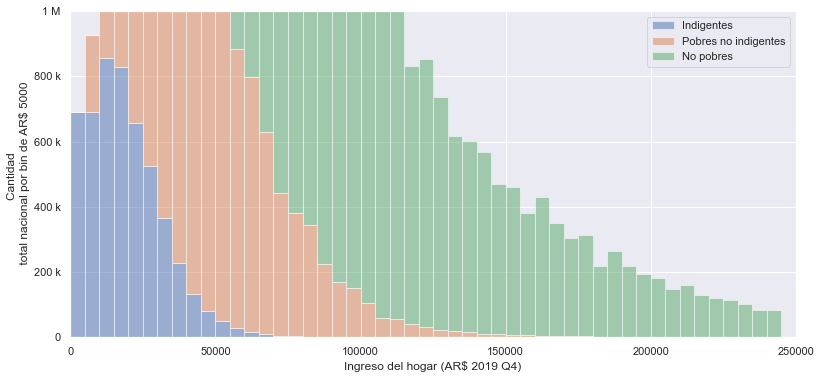

In [30]:
import numpy as np
from matplotlib.ticker import EngFormatter

plot_dist(data[['HOGAR_REF_ID', 'Q', 'P47T_hogar', 'Pobreza', 'Indigencia']].drop_duplicates(), variable = 'P47T_hogar', xmin = 0, 
          titulo = 'Ingreso del hogar (AR$ 2019 Q4)')

# plot_dist(data.loc[(data['P03'] > 24) & (data['P03'] > 34)], variable = 'P47T_persona', xmin = 0, 
#           titulo = 'Ingreso del hogar (AR$ 2019 Q4)')

## Lineas de Pobreza e indigencia

#### Total Pais

In [31]:
from IPython.display import display, HTML
# def pretty_print(df):
#     return display(HTML(df.to_html().replace("\\n","<br>")))

def pd_centered(df):
    return df.style.set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}])

In [32]:
# tabla_semestral = pd.read_csv('./../data/info/tabla_semestral.csv', index_col=0, header = [0, 1])
# table = tabla_semestral.drop(['PERSONA_REF_ID', 'CBA','CBT'], axis = 1)
# table = table.iloc[:, table.columns.get_level_values(1) != 'sum']
# table.index = pd.to_datetime(table.index, infer_datetime_format=True)
# table.index = table.index.to_period("6M")

# table[('Pobreza', 'mean')] = 100*table[('Pobreza', 'mean')]
# table[('Indigencia', 'mean')] = 100*table[('Indigencia', 'mean')]

# table.columns = pd.Index([('Ingreso Persona', 'promedio'), ('Ingreso Persona', 'mediana'),
#                 ('Ingreso Hogar', 'promedio'), ('Ingreso Hogar', 'mediana'),
#                 ('Ingreso Hogar sobre linea de pobreza', 'promedio'), ('Ingreso Hogar sobre linea de pobreza', 'mediana'),
#                 ('Pobreza (personas)', '%'), ('Indigencia (personas)', '%')])

# pd_centered(table.round({('Ingreso Persona', 'promedio'): -2, ('Ingreso Persona', 'mediana'): -2,
#                 ('Ingreso Hogar', 'promedio'): -2, ('Ingreso Hogar', 'mediana'): -2,
#                 ('Ingreso Hogar sobre linea de pobreza', 'promedio'): -2, ('Ingreso Hogar sobre linea de pobreza', 'mediana'): -2,
#                 ('Pobreza (personas)', '%'): 1, ('Indigencia (personas)', '%'): 1}))

\* En este cuadro, el calculo de ingresos medios incluye a toda la poblacion, tambien menores e inactivos.



## 'Linea de Pobreza'

Para este paso, se aplican la regla sugerida por INDEC de pobreza monetaria. 

**De donde sale***

Involucra usar un numero cercano a 2.5 que viene de la encuesta de Gastos de Hogares (ENGHO).
Es decir, esta es una linea de ~2.5 Canastas alimentarias. Este es un punto crucial ya que afecta el numerito final de resultado que vamos a tener. Los valores precisos van a estar en el apendix pero seria bueno tambien un calculo menos vulnerable al control. 
La canasta alimentaria al poder ser biologicamente establecida y con algunos estimadores economicos sencillos (cuanto cuesta comer lo necesario) es mas transparente. Tambien se presta a ser comparada en reglas internacionales, es decir sugerencias de valores PPP que representan un nivel medido de alimentacion.

***Como se calcula***
 - Se usan los 10 trimestres disponibles para entrenar. 
 - Los resultados del algoritmo de prediccion son ingresos de personas y hogares.
 - Nos permite predecir un output complicado, como puede ser una condicion en la ecuacion del hogar.
 - Aprovechamos que los ponderamientos se pueden lograr sampleando al azar de una muestra comprensiva (Censo 2010).
 - Se usan las proyecciones poblacionales por departamento (INDEC)
 - Todos los valores en pesos de 2019-Q4. Conviene deflactar mensualmente. 
 - Se usa promedio simple. En alta inflacion da cierto bias. Aunque igualmente, tambien nosotros perdemos idea de cuanto valia el peso en ese momento.
 
 

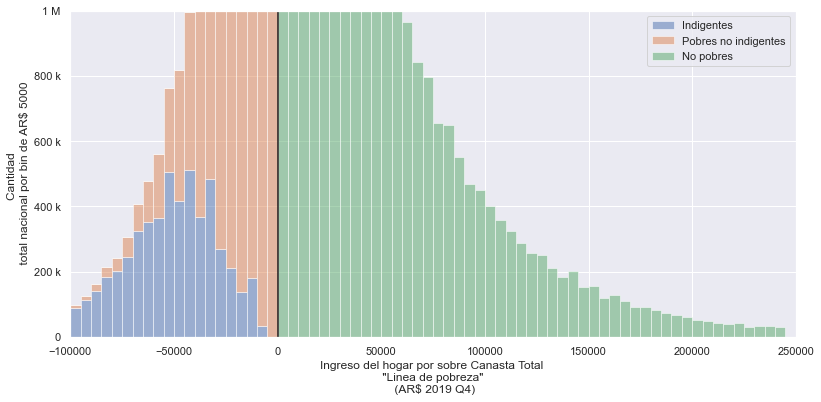

In [33]:
plot_dist(data, variable = 'gap_pobreza', xmin = -100000,
          titulo = 'Ingreso del hogar por sobre Canasta Total \n "Linea de pobreza" \n (AR$ 2019 Q4)')

***La linea de la canasta alimentaria***

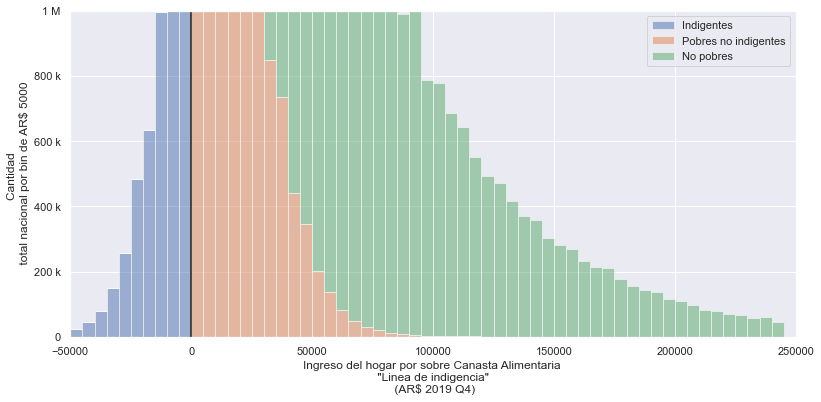

In [34]:
plot_dist(data, variable = 'gap_indigencia', xmin = -50000,
          titulo = 'Ingreso del hogar por sobre Canasta Alimentaria \n "Linea de indigencia" \n (AR$ 2019 Q4)')



Una vez que se hacen predicciones de ingresos y se calcula la 'Canasta Basica Alimentaria' de las personas de los hogares, calculamos la ecuacion en cada uno de los hogares y agregamos los resultados.

Esto nos deja ver una estructura detallada de la población de hogares que no llega pagar la canasta básica alimentaria de sus integrantes.

#### Canastas alimentaria y total, vs ingreso medio individual y de hogar.

Precios constantes de 2019-Q4. Los costos de canastas definidos post intervencion de 2016 se extienden hacia atras hasta 2003 para todos los calculos de pobreza.

In [35]:
# tabla_semestral_AGLOS = pd.read_csv('./../data/info/tabla_semestral_AGLOS.csv', index_col=0, header = [0, 1])
# table = tabla_semestral_AGLOS.drop(['PERSONA_REF_ID', 'CBA','CBT'], axis = 1)
# table = table.iloc[:, table.columns.get_level_values(1) != 'sum']
# table.index = pd.to_datetime(table.index, infer_datetime_format=True)
# table.index = table.index.to_period("6M")

# table[('Pobreza', 'mean')] = 100*table[('Pobreza', 'mean')]
# table[('Indigencia', 'mean')] = 100*table[('Indigencia', 'mean')]

# table.columns = pd.Index([('Ingreso Persona', 'promedio'), ('Ingreso Persona', 'mediana'),
#                 ('Ingreso Hogar', 'promedio'), ('Ingreso Hogar', 'mediana'),
#                 ('Ingreso Hogar sobre linea de pobreza', 'promedio'), ('Ingreso Hogar sobre linea de pobreza', 'mediana'),
#                 ('Pobreza (personas)', '%'), ('Indigencia (personas)', '%')])

# pd_centered(table.round({('Ingreso Persona', 'promedio'): -2, ('Ingreso Persona', 'mediana'): -2,
#                 ('Ingreso Hogar', 'promedio'): -2, ('Ingreso Hogar', 'mediana'): -2,
#                 ('Ingreso Hogar sobre linea de pobreza', 'promedio'): -2, ('Ingreso Hogar sobre linea de pobreza', 'mediana'): -2,
#                 ('Pobreza (personas)', '%'): 1, ('Indigencia (personas)', '%'): 1}))

In [44]:
cuadro5 = pd.read_csv('./../data/cuadros/cuadro4_'+str(frac)+'_ARG', index_col=[0, 1], header = [0, 1, 2])
df = cuadro5.iloc[:, cuadro5.columns.get_level_values(0).isin(['CBA', 'CBT', 'P47T_hogar', 'P47T_persona', 'gap_pobreza', ])
                 & cuadro5.columns.get_level_values(1).isin(['median', ])]

# Leave just time as index
df = df.unstack()

df.index = pd.DatetimeIndex(df.index)

# Rolling 4 trimestres de interpolado
df = df.resample('Q').mean().interpolate()

show = df.groupby(pd.Grouper(level = 0, freq = 'Y')).mean()
show.columns = show.columns.droplevel([1, 3])
show.columns = [('Canasta basica', 'alimentaria'), ('Canasta basica', 'total'), 
                ('Ingreso medio', 'hogar'), ('Ingreso medio', 'persona'),
                ('Brecha de hogares', 'todos'), ('Brecha de hogares', 'en pobreza')]
show.index = range(startyr, endyr)

# pd_centered(myround(show, 100).astype(int))

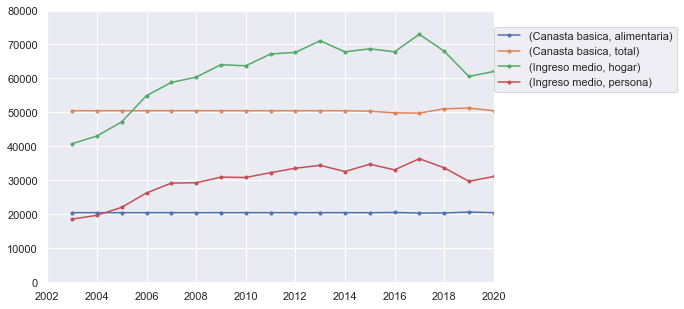

In [46]:
fig, ax = plt.subplots(figsize = (8, 5))
show.iloc[:, :4].plot(ax = ax, marker = '.')
plt.ylim(0, 8e4)
plt.xlim(2002, 2020)
ax.legend(loc = (1, .7))
plt.show()

## Variacion regional

In [47]:
# Datos Geograficos!
####

import geopandas as gpd

## Shapefiles de provincias
ref_provs = gpd.read_file('./../../IGN_INDEC_georef/IGN_shp/Provincia/')

### Shapefiles de Fracciones censales y departamentos
frac_gdf = gpd.read_file('./../../IGN_INDEC_georef/censos_shp_CONICET_dissolved/fracs_2010.shp')
dptos_gdf = gpd.read_file('./../../IGN_INDEC_georef/censos_shp_CONICET_dissolved/dptos_2010.shp')

# frac_gdf['personas'] = pd.to_numeric(frac_gdf['personas'])
# dptos_gdf['personas'] = pd.to_numeric(dptos_gdf['personas'])

fancy_crs = {u'lat_0': -35,
 u'lon_0': -65,
 u'no_defs': True,
 u'proj': u'ortho',
 u'units': u'm',
 u'x_0': -65,
 u'y_0': -35,
 u'a' : 6371000, 
 u'b' : 6371000}

# dptos_gdf = dptos_gdf.to_crs(fancy_crs)
# crs = {'init': 'epsg:4326'} #latlong
#  = ...to_crs({'init': 'epsg:3395'}) # en metrico

In [48]:
radio_ref = pd.read_csv('./../data/info/radio_ref.csv')

aglo_labels = pd.read_csv('./../data/info/aglo_labels.csv')[['AGLOMERADO', 'NOMAGLO']]
dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')

radio_ref = radio_ref.merge(aglo_labels).merge(dpto_region)
radio_ref = radio_ref[['RADIO_REF_ID', 'NOMDPTO','NOMPROV', 'AGLOMERADO', 'NOMAGLO', 'Region', 'IDPROV', 'IDDPTO', 'IDFRAC']]

radio_ref['PROV_'] = radio_ref.IDPROV.astype(str).str.zfill(2)
radio_ref['DEPTO_'] = radio_ref.IDDPTO.astype(str).str.zfill(3)
radio_ref['FRACC_'] = radio_ref.IDFRAC.astype(str).str.zfill(2)

In [49]:

data = pd.read_csv('./../data/Pobreza/pobreza_'+str(frac)+'_2019.csv')
data['Grupo Etario'] = pd.cut(data.P03, np.arange(-1, 80, 3))#.round(-1) ## Customizar grupo etario

data = data.merge(radio_ref[['RADIO_REF_ID', 'PROV_','DEPTO_','FRACC_']], how = 'left')

In [50]:
### Matriz que da origen a las barritas de abajo.

data_hogares = data.groupby('HOGAR_REF_ID').first()
data_hogares = data_hogares.merge(radio_ref[['RADIO_REF_ID', 'Region', 'NOMPROV', 'NOMAGLO']].drop_duplicates())
data_hogares['Region'] = data_hogares['Region'].replace('Gran Buenos Aires', 'AMBA')
data_hogares['pctil'], bins_hogares = pd.qcut(data_hogares.P47T_hogar, 15, retbins=True)

df = data_hogares.groupby(['Region', 'pctil'])[['P47T_hogar']].count().unstack()
# df = df.div(df.sum(1), 0)#.round(3)

df_CABA = data_hogares.groupby(['NOMPROV', 'pctil'])[['P47T_hogar']].count().unstack().loc[['Ciudad Autónoma de Buenos Aires']]
# df_CABA = df_CABA.div(df_CABA.sum(1), 0)

df_GBA = data_hogares.groupby(['NOMAGLO', 'pctil'])[['P47T_hogar']].count().unstack().loc[['GBA']]
# df_GBA = df_GBA.div(df_GBA.sum(1), 0)

df = pd.concat([df_CABA, df_GBA, df])

df = df.reindex(['Noroeste', 'Noreste','Ciudad Autónoma de Buenos Aires', 'GBA', 'Cuyo', 'Pampeana', 'Patagónica'])

In [51]:
tot_reg = data_hogares.groupby('Region').count().iloc[:, 0]/frac/yrs_pob_data
totprovs = data_hogares.groupby('NOMPROV').count().iloc[:, 0]/frac/yrs_pob_data
totaglos = data_hogares.groupby('NOMAGLO').count().iloc[:, 0]/frac/yrs_pob_data

tot_hogares = pd.concat([tot_reg, totprovs, totaglos])

In [52]:

# data['link'] = data['DPTO'].astype(str).str.zfill(5)

# pob_dpto = data.groupby('link')[['Pobreza']].mean().reset_index()


El cuadro de deciles de ingreso muestra valores nacionales. Sin embargo ¿Cómo se distribuyen las poblaciones regionales entre estos grupos de ingreso?


In [53]:
## Mapa de pobreza por provincias
## Tomar valores de pobreza
pob_prov = data.groupby(['PROV_'])[['Pobreza']].mean().reset_index()

## Unir info geografica
pobreza_gdf = gpd.GeoDataFrame(pob_prov.merge(ref_provs[['IN1', 'NAM', 'geometry']], left_on = 'PROV_', right_on = 'IN1'))

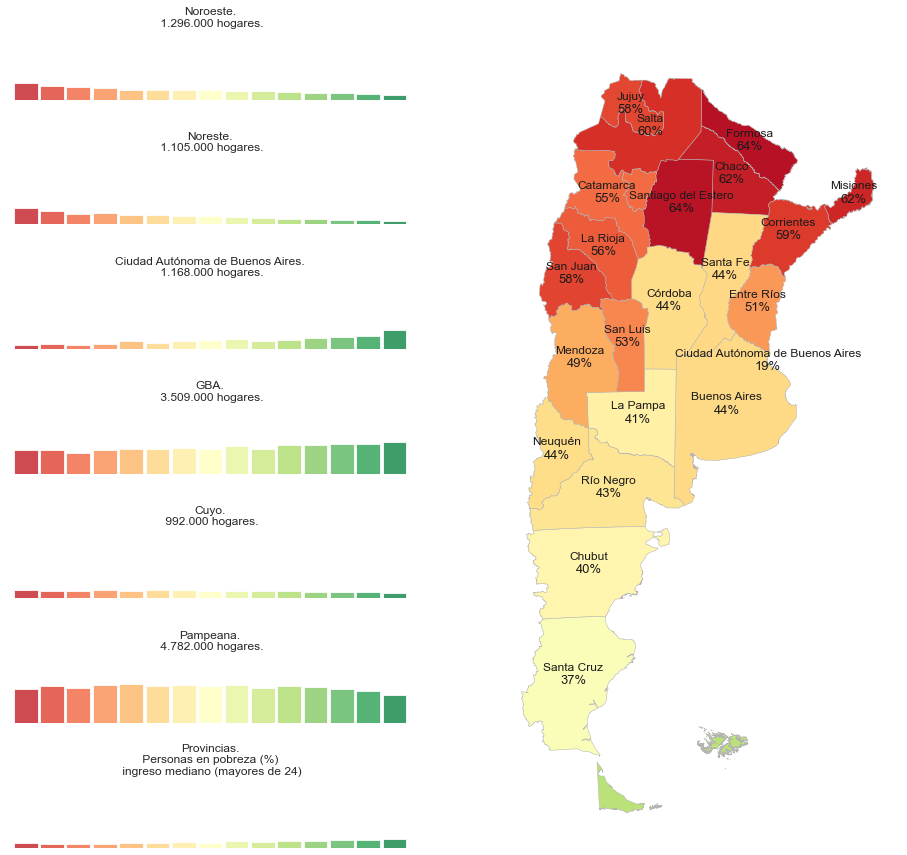

In [54]:
import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True, figsize = (16, 15))
spec = gridspec.GridSpec(ncols=2, nrows=len(df), figure=fig)

# ##########################################


for i in range(len(df)):
#     ax = axs[i]
    ax = fig.add_subplot(spec[i, 0])
    (df.iloc[i]/yrs_pob_data).plot(kind = 'bar', ax = ax, width = .9, color = sns.color_palette("RdYlGn", 15), alpha = .8)# colormap = 'RdYlGn')
    lugar = df.index[i]
    ax.set_title(lugar + '.\n '+str('{:,}'.format(int(np.round(tot_hogares.loc[lugar], -3))).replace(',', '.'))+' hogares.')
    ax.set_xlabel('Percentiles nacionales de ingreso', fontsize = 10)
    ax.set_ylim(0, 12000)
    ax.axis('off')
    plt.subplots_adjust(hspace = 0.85)
    
# ##########################################

    # MAPA PROVINCIAS
plt.title('Provincias.\n Personas en pobreza (%) \n ingreso mediano (mayores de 24)')

# Elegir crs
# crs = {'init': 'epsg:3395'}
crs = fancy_crs
pobreza_gdf_crs = pobreza_gdf.to_crs(crs)

ax = fig.add_subplot(spec[:, 1])

# Carteles
for i, row in pobreza_gdf_crs.loc[~pobreza_gdf.NAM.isin(['Tucumán', 'Tierra del Fuego, Antártida e Islas del Atlántico Sur'])].iterrows(): # Sacamos esta provs para que no se superpongan los cartelitos
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    
#     ingreso_mediano = '$'+str(int(myround(row.P47T_persona,500)))
    pobreza = str(int(round(100*row.Pobreza)))+'%'

    ax.text(x, y + 40000, row.NAM, fontsize=12, color = '.1', horizontalalignment = 'center')
    ax.text(x, y - 25000, pobreza, fontsize=13, color = '.1', horizontalalignment = 'center')
#     ax.text(x, y - 70000, ingreso_mediano, fontsize=11, color = '.1', horizontalalignment = 'center')


# Provincias
# provs_gdf.plot(column = 'P47T_persona', ax = ax, vmin = 10000, vmax = 35000, cmap = 'RdYlGn')
pobreza_gdf_crs.plot(column = 'Pobreza', ax = ax, vmin = .1, vmax = .66, cmap = 'RdYlGn_r', edgecolor = '.7', lw = 0.5)


# # Encuadre ARG
if crs == {'init': 'epsg:3395'}:
    ax.set_xlim(-8300000, -5750000)
    ax.set_ylim(-7450000, -2400000)
elif crs == fancy_crs:
    ax.set_xlim(-.75e6, 1.25e6)
    ax.set_ylim(-2.3e6, 1.6e6)

# ax.set_xlabel('A')
ax.axis('off')


plt.show()


# fig.colorbar(im, ax=ax, orientation="horizontal")
# divider = make_axes_locatable(ax)
# cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
# fig.add_axes(cax)
# fig.colorbar(im, cax=cax, orientation="horizontal")

# El error en ingreso medio por provincia esta en los 500 a 1000 pe
# En la cifra de pobreza el error es de 1%

## Tamaño de la vivienda. Hacinamiento.

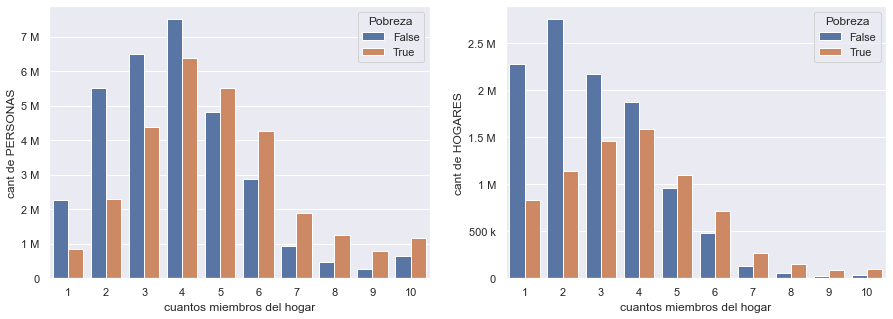

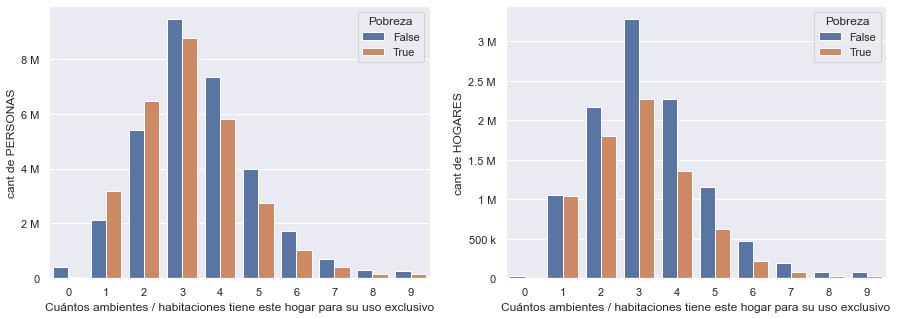

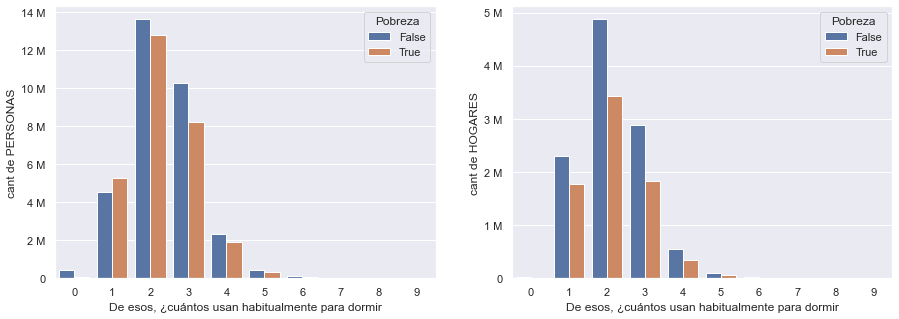

In [55]:

data = pd.read_csv('./../data/Pobreza/pobreza_'+str(frac)+'_2019.csv')#.reset_index().rename(columns = {'index': 'PERSONA_REF_ID'})

import numpy as np
from matplotlib.ticker import EngFormatter
# cat_cols = ['V01', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10',
#        'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'PROP',
#        'P02', 'P05', 'P07', 'P08', 'P09', 'P10', 'CAT_OCUP',
#        'CAT_INAC', 'CH07', 'PP07G1', 'PP07G2', 'PP07G3', 'PP07G4', 'PP07G_59',
#        'PP07H', 'PP07I', 'PP07J', 'PP07K',
#        'AGLOMERADO', 'CONDACT', 'Grupo Etario'] # IX_TOT
# value_cols = 'P47T' #?

data['IX_TOT'] = np.clip(data.IX_TOT, 0, 10)
data['H15'] = np.clip(data.H15, 0, 9)

cat_cols = ['IX_TOT', 'H16', 'H15']

vn = pd.read_csv('./../data/info/VARIABLE_NAMES.csv')
# vn['Pregunta'] = vn['Pregunta'].str.strip()#.str.replace("'", "") Don't run
# data = data.reset_index().rename(columns = {'index': 'PERSONA_REF_ID'}) # parche porque no esta la columna

for cat in cat_cols:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
    info = data.groupby([cat, 'Pobreza'])[['PERSONA_REF_ID', 'HOGAR_REF_ID']].nunique()
    info_pct = (100*(info.unstack()/info.unstack().sum()).stack())
    
    sns.barplot(x=cat, y="PERSONA_REF_ID", hue="Pobreza", data=(info/frac/yrs_pob_data).reset_index(), ax = ax1)
    xlab = ''
    try:
        xlab = vn.loc[vn.Censo == cat]['Pregunta'].values[0]
    except:
        try:
            xlab = vn.loc[vn.EPH == cat]['Pregunta'].values[0]
        except:
            pass
    ax1.set(xlabel= xlab, ylabel = 'cant de PERSONAS')
    ax1.yaxis.set_major_formatter(EngFormatter())
    sns.barplot(x=cat, y="HOGAR_REF_ID", hue="Pobreza", data=(info/frac/yrs_pob_data).reset_index(), ax = ax2)
    ax2.set(xlabel= xlab, ylabel = 'cant de HOGARES')
    ax2.yaxis.set_major_formatter(EngFormatter())
    plt.show()

## Pobreza por grupo etario

In [56]:
# pd.cut(data.P03)
yrs_pob_data = 1

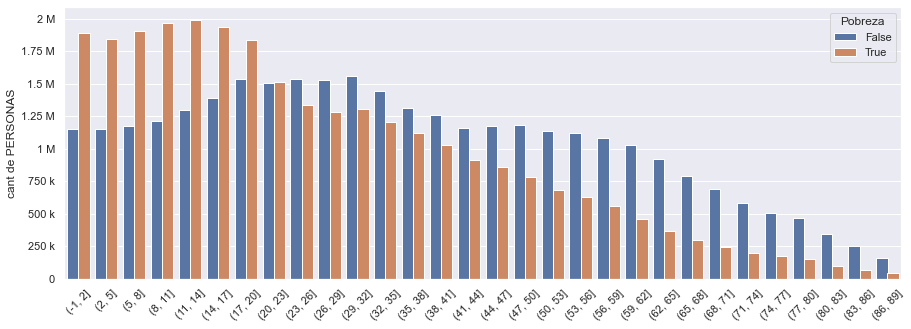

In [57]:
data['Grupo Etario'] = pd.cut(data.P03, np.arange(-1, 90, 3))

cat = 'Grupo Etario'

vn = pd.read_csv('./../data/info/VARIABLE_NAMES.csv')
# vn['Pregunta'] = vn['Pregunta'].str.strip()#.str.replace("'", "") Don't run

fig, ax = plt.subplots(1, figsize = (15, 5))
info = data.groupby([cat, 'Pobreza'])[['PERSONA_REF_ID']].nunique()
sns.barplot(x=cat, y="PERSONA_REF_ID", hue="Pobreza", data=(info/frac/yrs_pob_data).reset_index(), ax = ax)
xlab = ''
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_major_formatter(EngFormatter())
ax.set(xlabel= xlab, ylabel = 'cant de PERSONAS')
plt.show()

In [58]:
# ## Upper tail

# data['income_bin'] = pd.cut(np.log10(data['P47T_persona']).replace(-np.inf, 1), 100)

# fig, ax = plt.subplots(1, figsize = (5, 6))

# pdf_info = data.groupby('income_bin')['PERSONA_REF_ID'].count().reset_index()
# pdf_info['PERSONA_REF_ID'] = pdf_info['PERSONA_REF_ID']/frac/yrs_pob_data

# pdf_info['pdf'] = pdf_info['PERSONA_REF_ID']/pdf_info['PERSONA_REF_ID'].sum()
# pdf_info['cdf'] = pdf_info['pdf'].cumsum()

# np.log10(1 - pdf_info.iloc[60:85].set_index('income_bin')[['cdf']]).reset_index().plot(x = 'income_bin', y = 'cdf', marker = '.', ax = ax)
# ax.tick_params(axis='x', rotation=45)

# pdf_info.tail(20)

## Ingresos, pobreza e indigencia por niveles educativos

En este cuadro, los ingresos medios, porcentaje de pobreza e indigencia segun nivel educativo.

In [59]:
cuadro = pd.read_csv('./../data/cuadros/cuadro3_'+str(frac)+'_ARG', index_col=[0, 1], header = [0, 1, 2])

cuadro = cuadro.loc['2003':].drop(('P47T_persona', 'mean', 'Mayores de 24'), axis = 1)
cuadro.columns = ['Indigencia (%)', 'Ingresos (mediana)', 'Pobreza (%)']
cuadro = cuadro.unstack().mean().unstack().T

cuadro = cuadro[['Ingresos (mediana)', 'Pobreza (%)', 'Indigencia (%)']]
cuadro = cuadro.loc[[2, 20, 21, 40, 41, 60, 61, 70, 71, 80, 81]]

data_sel = data[['P03','P0910']]
counts = data_sel.loc[data_sel.P03 > 24]['P0910'].value_counts()
counts_pct = (100*counts.loc[[2, 20, 21, 40, 41, 60, 61, 70, 71, 80, 81]]/counts.sum()).round(1)

cuadro = pd.concat([cuadro, counts_pct], axis = 1)
cuadro = cuadro.rename(columns = {'P0910':'Poblacion (%)'})
cuadro.index = ['No asistió', 'Primaria', 'P. completa', 'Secundaria','S. completa', 'Terciario', 'T. completo', 
             'Universidad', 'U. completa', 'Postgrado', 'P. completo']

cuadro = cuadro.round({'Ingresos (mediana)': -2, 'Pobreza (%)': 1, 'Indigencia (%)': 1, 'Poblacion (%)': 1})
cuadro.style.bar(subset = ['Poblacion (%)'], vmin = 0).format("{:.1f}")

,Ingresos (mediana),Pobreza (%),Indigencia (%),Poblacion (%)
No asistió,17700.0,49.8,17.1,2.2
Primaria,19000.0,48.5,16.6,13.2
P. completa,22100.0,43.3,13.1,27.6
Secundaria,28000.0,41.3,11.5,13.7
S. completa,36300.0,27.9,6.2,19.6
Terciario,38300.0,24.5,5.7,2.9
T. completo,47100.0,14.4,2.3,6.3
Universidad,44000.0,16.3,3.3,5.9
U. completa,67700.0,7.1,1.2,6.9
Postgrado,65200.0,7.2,1.5,0.3


*Mayores de 24 años

## Dependencia geografica
### Porcentaje de personas en pobreza por departamento.

In [60]:
import geopandas as gpd

In [61]:
aglo_labels = pd.read_csv('./../data/info/aglo_labels.csv')[['AGLOMERADO', 'NOMAGLO']]

radio_ref = pd.read_csv('./../data/info/radio_ref.csv')
# radio_ref[['PROV','NOMPROV','DPTO', 'NOMDPTO']].drop_duplicates().to_csv('./data/DPTO_PROV.csv', index = False)
dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
radio_ref = radio_ref.merge(dpto_region)
radio_ref = radio_ref[['RADIO_REF_ID', 'NOMDPTO','NOMPROV', 'AGLOMERADO', 'Region', 'IDPROV', 'IDDPTO', 'IDFRAC']].drop_duplicates().merge(aglo_labels)

radio_ref['PROV_'] = radio_ref.IDPROV.astype(str).str.zfill(2)
radio_ref['DEPTO_'] = radio_ref.IDDPTO.astype(str).str.zfill(3)
radio_ref['FRACC_'] = radio_ref.IDFRAC.astype(str).str.zfill(2)


data = pd.read_csv('./../data/Pobreza/pobreza_'+str(frac)+'_2019.csv')
data = data.merge(radio_ref[['RADIO_REF_ID', 'PROV_','DEPTO_','FRACC_']], how = 'left')

In [62]:
## Data que tenga las keys de radio a fracs, de radio a dpto IGN,

## Data que tenga shapes e los radios disueltos en fracciones o en deptos IGN

In [63]:
## Tomar valores de pobreza
pob_frac = data.loc[data.PROV.isin([2, 6])].groupby(['PROV_', 'DEPTO_', 'FRACC_'])[['Pobreza']].mean().reset_index()
# pob_frac = data.loc[data.AGLOMERADO.isin([32])].groupby(['IDFRAC','DPTO'])[['Pobreza']].mean().reset_index()
# pob_frac = data.loc[data.PROV.isin([82])].groupby(['IDFRAC','DPTO'])[['Pobreza']].mean().reset_index()
# pob_frac = data.loc[data.AGLOMERADO.isin([25])].groupby(['IDFRAC','DPTO'])[['Pobreza']].mean().reset_index()

## Unir info geografica
pobreza_gdf = gpd.GeoDataFrame(pob_frac.merge(frac_gdf))

# Fill na with median. Esp for areas of little pop.
# # data.groupby('DPTO').count().iloc[:, 0].sort_values(ascending = False).head(10)
# pobreza_gdf.loc[pobreza_gdf.personas < 3000, 'Pobreza'] = np.nan
# pobreza_gdf = pobreza_gdf.fillna(pob_dpto_gdf.Pobreza.median())

gdf = pobreza_gdf#.plot(column = 'Pobreza')

In [64]:
from shapely.geometry import box

In [65]:
fracs_GBA_gdf = gpd.GeoDataFrame(radio_ref.loc[radio_ref.AGLOMERADO == 33][['PROV_','DEPTO_']].drop_duplicates().merge(frac_gdf[['PROV_','DEPTO_', 'FRACC_', 'geometry']]))

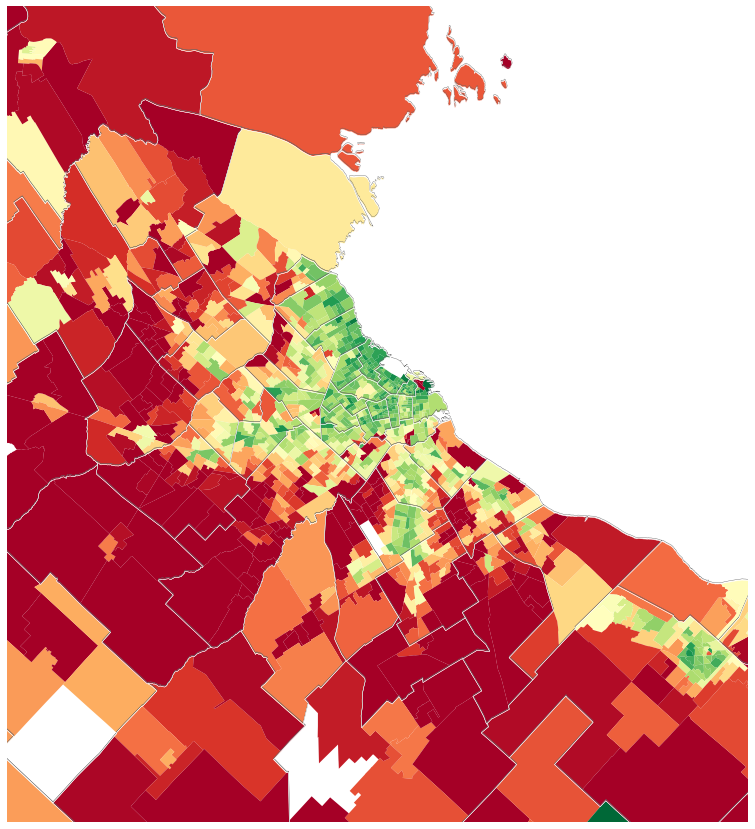

In [66]:
fig, ax = plt.subplots(1, figsize = (15, 15))

## Bordes de Departamento (doble linea)
bordes_dptos = dptos_gdf.loc[dptos_gdf.PROV_.isin(['02', '06'])].to_crs({'init': 'epsg:3395'})
bordes_dptos.translate(yoff = 220, xoff = 30).plot(color = 'None', edgecolor = '.4', lw = .4, ax = ax, zorder = 10)
bordes_dptos.translate(yoff = 0, xoff = 0).plot(color = 'None', edgecolor = 'w', lw = .4, ax = ax, zorder = 10)

gdf.fillna(0).to_crs({'init': 'epsg:3395'}).plot(column = 'Pobreza', ax = ax, vmin = 0, vmax = .6, cmap = 'RdYlGn_r', lw = 0)

# plot bounds
custom_bounds = fracs_GBA_gdf.to_crs({'init': 'epsg:3395'}).total_bounds
x0, y0, x1, y1 = box(*custom_bounds).buffer(-15000).bounds 
# minx, miny, maxx, maxy

ax.set_xlim(x0, x1); ax.set_ylim(y0, y1)
ax.axis('off')

# ejido = gpd.read_file('./../../Documents/censo_geo/ejidos/ejido_BA', driver='GeoJSON')
# ejido.loc[[1]].to_crs({'init': 'epsg:3395'}).plot(color = 'w', ax = ax)

plt.savefig("./mapa_portada.png")
plt.show()

In [67]:
## Tomar valores de pobreza
pob_dpto = data.groupby(['PROV_', 'DEPTO_'])[['Pobreza']].mean().reset_index()

## Unir info geografica
pobreza_dpto_gdf = gpd.GeoDataFrame(pob_dpto.merge(dptos_gdf))
gdf = pobreza_dpto_gdf

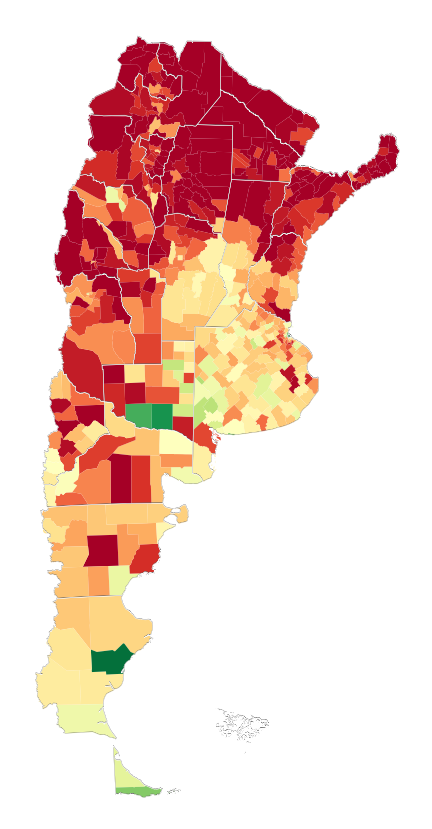

In [68]:

# Elegir crs
# crs = {'init': 'epsg:3395'}
crs = fancy_crs

fig, ax = plt.subplots(1, figsize = (8, 15))
## Pobreza deptos
gdf.fillna(0).to_crs(crs).plot(column = 'Pobreza', ax = ax, vmin = .1, vmax = .65, cmap = 'RdYlGn_r', lw = 0)

# Bordes provincias (doble linea)
ref_provs.to_crs(crs).translate(yoff = 2200, xoff = 300).plot(color = 'None', edgecolor = '.4', lw = .4, ax = ax, zorder = 10)
ref_provs.to_crs(crs).translate().plot(color = 'None', edgecolor = 'w', lw = .4, ax = ax, zorder = 10)

# # Encuadre ARG
if crs == {'init': 'epsg:3395'}:
    ax.set_xlim(-8300000, -5750000)
    ax.set_ylim(-7450000, -2400000)
elif crs == fancy_crs:
    ax.set_xlim(-.75e6, 1.25e6)
    ax.set_ylim(-2.3e6, 1.6e6)

plt.axis('off')
plt.show()

### Porcentaje de personas en pobreza por fraccion censal.
#### Ejido Urbano AMBA

# Dependencia Temporal

In [69]:
# df = pd.read_csv('./../data/cuadros/cuadro_AGLO_si_Q_pct', index_col=[0, 1], header = [0, 1]).unstack(0, 1)
# df.index = pd.DatetimeIndex(df.index, freq = 'Q')

# df_ = df[['Indigencia', 'Pobreza']].groupby(pd.Grouper(level = 0, freq = '6MS')).mean().T
# df_.index = pd.MultiIndex.from_tuples([(x[0], x[1], 'Aglomerados' if x[2] else 'Resto') for x in df_.index])
# show = df_.copy()
# show.columns = show.columns.to_period("6M")
# show

### Porcentajes, provincias. (2019)

In [70]:
cuadro2 = pd.read_csv('./../data/cuadros/cuadro1_'+str(frac)+'_ARG', index_col=[0, 1], header = [0, 1, 2])
df = cuadro2.iloc[:, cuadro2.columns.get_level_values(0).isin(['Indigencia', 'Pobreza'])
            & cuadro2.columns.get_level_values(2).isin(['Hogares', 'Personas'])
                 & cuadro2.columns.get_level_values(1).isin(['mean'])]

# Leave just time as index
df = df.unstack()

df.index = pd.DatetimeIndex(df.index)

# Ultimo periodo
x = df.loc['2018'].mean().unstack([3, 1])
# x.columns = ['Fuera de aglomerados', 'Aglomerados']

# myround(x, 20).astype(int)
x.columns = x.columns.droplevel(1)
display(x.T.reindex(x.T.sum(1).sort_values(ascending = False).index).round(1))

# Rolling 4 trimestres de interpolado
df = df.resample('Q').mean().interpolate()

Indigencia          Pobreza         
        Hogares Personas Hogares Personas
PROV                                     
34         18.0     23.5    48.0     58.3
86         17.4     22.3    46.7     57.2
54         16.4     22.2    45.3     56.8
22         16.5     21.7    45.5     55.8
18         15.3     20.1    43.0     53.8
66         15.1     18.9    43.3     52.7
70         12.5     16.4    42.5     52.6
90         13.9     16.7    41.3     49.7
38         12.9     15.5    40.5     48.5
10         12.9     16.1    38.8     48.3
46          9.3     11.5    39.2     48.0
30          9.1     12.6    35.3     45.2
74          8.0     10.8    35.5     45.4
50          8.0     10.6    34.1     43.8
82          8.4     11.3    31.3     40.2
14          7.8     10.5    30.6     39.7
6           7.5     10.0    30.3     38.8
42          7.4     10.9    28.1     37.3
58          6.7      8.2    28.6     35.1
62          6.5      7.7    28.2     35.2
26          5.6      7.2    26.1     32.7
78          4.7      6.0    23.6     29.9
94          3.7      4.5    17.4     22.9
2           3.1      3.9    11.4     15.4

In [71]:
# # Niveles
# show = df.groupby(pd.Grouper(level = 0, freq = 'Y')).mean()
# show.columns = show.columns.droplevel(1)
# show.index = range(2007, 2019)

In [73]:
# diferencia
show = df.diff(4).groupby(pd.Grouper(level = 0, freq = 'Y')).mean()
show.columns = show.columns.droplevel(1)
show.columns = show.columns.swaplevel(0, 2).swaplevel(1,2)
show.index = range(startyr, endyr)

choice = np.random.choice(show.columns.get_level_values('PROV').unique(), 10)

# show.T.loc[choice].sort_index().round(1).style.applymap(color_negative_red)
show.T[show.columns.get_level_values('PROV').isin(choice)].dropna(1).sort_index().round(1).style.applymap(color_negative_red).format("{:.1f}")

## Niveles (%)
### Por Region y aglomerado. Promedio 2019.

In [74]:
cuadro = pd.read_csv('./../data/cuadros/cuadro0_'+str(frac)+'_ARG', index_col=[0, 1, 2], header = [0, 1, 2])
df = cuadro.iloc[:, cuadro.columns.get_level_values(0).isin(['Indigencia', 'Pobreza'])
            & cuadro.columns.get_level_values(2).isin(['Hogares', 'Personas'])
                 & cuadro.columns.get_level_values(1).isin(['mean'])]

# Leave just time as index
df = df.unstack([1, 2]).dropna(1)
df.index = pd.DatetimeIndex(df.index)

# Ultimo periodo
x = df.loc['2018'].mean().unstack([3, 4, 1]).dropna(1)
# # x.columns = ['Fuera de aglomerados', 'Aglomerados']
# # myround(x, 20).astype(int)
x.columns = x.columns.droplevel(-1)
display(x.T.reindex(x.T.sum(1).sort_values(ascending = False).index).round(1))

# # Rolling 4 trimestres de interpolado
# df = df.resample('Q').mean().interpolate()

Indigencia          Pobreza         
                                Hogares Personas Hogares Personas
Region            AGLOMERADO                                     
Noreste           0                19.3     25.7    50.1     61.6
Noroeste          0                18.8     23.5    50.2     60.2
Pampeana          33               11.7     15.3    42.8     52.1
Cuyo              0                11.4     15.1    42.4     53.0
Noreste           15               13.1     16.4    40.0     48.8
Pampeana          14               11.3     14.7    39.9     51.4
Noreste           12               10.9     13.2    36.4     44.8
Cuyo              27                9.3     12.2    36.6     45.9
Noroeste          18               10.2     12.5    36.1     44.8
                  23               10.5     12.7    35.2     43.4
Noreste           8                10.2     13.0    35.0     43.2
Cuyo              25                8.3     10.6    36.8     45.2
Noroeste          29               10.8     12.7    35.0     42.2
Noreste           7                10.1     13.3    33.4     43.6
Cuyo              26                7.6     10.0    33.8     43.4
Pampeana          5                 9.5     12.5    31.8     40.9
Noroeste          22                9.7     11.7    31.8     40.6
                  19                9.4     10.6    32.8     39.0
Pampeana          0                 7.8     10.7    31.5     40.4
Gran Buenos Aires 33                7.9     10.3    31.3     39.6
Pampeana          38                7.5     10.1    31.4     39.6
                  13                7.4     10.1    28.5     37.5
                  4                 7.7     10.2    28.6     36.8
                  6                 6.6      9.0    28.1     36.9
Patagónica        0                 6.7      8.3    29.3     36.3
Cuyo              10                5.6      7.3    27.9     36.5
Pampeana          93                3.8      5.6    30.1     37.8
Patagónica        91                5.6      7.5    27.9     36.1
Pampeana          30                6.1      8.7    26.4     35.0
                  36                6.4      8.5    26.7     34.6
                  34                5.6      7.7    23.8     32.5
Patagónica        17                5.6      6.7    24.6     30.9
Pampeana          2                 5.5      7.7    23.2     30.5
                  3                 4.5      6.0    22.4     29.6
Patagónica        9                 4.9      5.7    21.6     26.2
                  93                3.5      4.4    20.6     26.7
                  20                3.8      4.5    20.6     26.2
Gran Buenos Aires 0                 3.1      8.1    13.0     22.4
Patagónica        31                3.1      3.8    14.9     19.7
Gran Buenos Aires 32                3.1      3.8    11.4     15.3

## Cambio en niveles (%)
### Por aglomerado en regiones.

In [75]:
# diferencia
show = df.diff(4).groupby(pd.Grouper(level = 0, freq = 'Y')).mean()
show.columns = show.columns.droplevel(1)
show.columns = show.columns.swaplevel(0,2).swaplevel(1,3)
show.index = range(startyr, endyr)

# choice = np.random.choice(, 10)
show = show.T.sort_index().round()

for region in show.index.get_level_values('Region').unique():
    display(md('#### '+region))
    display(show.loc[region].style.applymap(color_negative_red).format("{:.0f}"))

#### Cuyo

#### Gran Buenos Aires

#### Noreste

#### Noroeste

#### Pampeana

#### Patagónica

## Niveles (%)
### Partidos y Comunas del AMBA (muestreo)

In [76]:
# fig, ax = plt.subplots(1, figsize = (8, 8))
# gdf.fillna(0).plot(column = 'Pobreza', ax = ax, vmin = .1, vmax = .65, cmap = 'RdYlGn_r',
#                                                  edgecolor = '.4', lw = 0)
# #Partidos b&n
# gdf.to_crs({'init': 'epsg:3395'}).fillna(0).plot(column = 'Pobreza', ax = ax, vmin = .1, vmax = .65, cmap = 'RdYlGn_r',
#                                                  edgecolor = '.4', lw = 0)
# dptos_gdf.to_crs({'init': 'epsg:3395'}).loc[dptos_gdf.to_crs({'init': 'epsg:3395'}).codpcia.isin(['02', '06'])].translate(yoff = 220, xoff = 30).plot(color = 'None', edgecolor = '.4', lw = .4, ax = ax, zorder = 10)
# dptos_gdf.to_crs({'init': 'epsg:3395'}).loc[dptos_gdf.to_crs({'init': 'epsg:3395'}).codpcia.isin(['02', '06'])].translate(yoff = 0, xoff = 0).plot(color = 'None', edgecolor = 'w', lw = .4, ax = ax, zorder = 10)

# plt.xlim(-6570000, -6450000)
# plt.ylim(-4150000, -4020000)
# # ax.set_xlim(530e5, 7e5)
# # ax.set_ylim(-25000, 75000)
# plt.axis('off')

# plt.show()

In [77]:

cuadro = pd.read_csv('./../data/cuadros/cuadro5_'+str(frac)+'_AMBA', index_col=[0, 1], header = [0, 1, 2])
df = cuadro.iloc[:, cuadro.columns.get_level_values(0).isin(['Indigencia', 'Pobreza'])
            & cuadro.columns.get_level_values(2).isin(['Hogares', 'Personas'])
                 & cuadro.columns.get_level_values(1).isin(['mean'])]

# Dptos de codigo a nombres...
dptos = pd.read_csv('./../data/info/radio_ref.csv')[['DPTO','NOMDPTO']].drop_duplicates().set_index('DPTO')
nomdptos = dptos.to_dict()['NOMDPTO']
df.index = pd.MultiIndex.from_tuples([(x[0], nomdptos[x[1]]) for x in df.index])

# Leave just time as index
df = df.unstack()

df.index = pd.DatetimeIndex(df.index)

# Ultimo periodo
x = df.loc['2018'].mean().unstack([3, 1])
# x.columns = ['Fuera de aglomerados', 'Aglomerados']

# myround(x, 20).astype(int)
x.columns = x.columns.droplevel(1)
display(x.T.reindex(x.T.sum(1).sort_values(ascending = False).index).round(1))

# Rolling 4 trimestres de interpolado
df = df.resample('Q').mean().interpolate()

Indigencia          Pobreza         
                       Hogares Personas Hogares Personas
Presidente Perón          14.3     18.4    51.0     60.3
Marcos Paz                13.0     17.7    45.9     57.0
San Vicente               13.8     20.1    43.0     54.8
General Rodríguez         13.0     16.9    45.6     55.8
Florencio Varela          13.1     16.6    45.3     54.2
Moreno                    12.0     15.1    42.6     51.0
Pilar                     11.7     14.9    42.2     51.5
José C. Paz               11.6     13.6    42.6     50.7
Ezeiza                    12.2     14.6    42.3     48.4
Merlo                     11.0     14.0    39.5     48.7
Escobar                    9.2     12.0    38.5     46.2
Esteban Echeverría         8.7     11.3    36.9     44.9
La Matanza                 9.0     11.1    36.3     44.3
Malvinas Argentinas        9.2     11.7    36.3     43.4
Almirante Brown            8.6     11.2    33.7     41.9
Berazategui                8.3     10.6    32.8     40.8
Comuna 08                  9.6     11.2    31.4     39.3
Quilmes                    7.7     10.2    30.0     38.2
Tigre                      7.4      8.9    31.3     38.2
Lomas de Zamora            7.8     10.0    29.5     37.7
San Miguel                 8.1      9.8    30.2     36.6
Berisso                    6.8      8.7    29.2     37.4
San Fernando               6.4      8.1    25.2     33.9
Ensenada                   5.0      6.3    28.3     33.8
Lanús                      5.5      7.4    24.2     31.0
General San Martín         5.3      6.9    24.0     31.9
Hurlingham                 4.6      5.9    24.9     30.9
Avellaneda                 5.1      7.2    23.0     30.3
La Plata                   5.3      7.7    22.2     29.5
Ituzaingó                  5.0      6.0    22.9     29.2
Comuna 04                  5.5      7.2    19.5     26.7
Tres de Febrero            4.2      6.0    19.5     25.8
Morón                      3.9      5.6    16.9     22.8
Comuna 07                  4.7      6.4    15.1     20.5
San Isidro                 3.2      4.2    15.8     21.5
Comuna 09                  3.1      3.7    15.0     19.8
Comuna 01                  4.6      4.8    14.5     16.8
Comuna 03                  2.7      3.2    10.4     13.4
Comuna 10                  2.3      2.9    10.6     13.6
Vicente López              1.9      2.0    10.8     14.1
Comuna 15                  2.1      2.9     9.4     13.3
Comuna 02                  3.7      3.2     8.6      9.1
Comuna 05                  1.9      1.9     8.3     11.3
Comuna 11                  1.5      1.7     8.4     10.9
Comuna 12                  1.3      1.5     7.9     10.0
Comuna 13                  1.7      1.7     6.6      8.1
Comuna 14                  2.0      2.0     6.4      7.6
Comuna 06                  1.3      1.3     6.6      8.1

## Cambio en niveles (%)

In [84]:
# diferencia
show = df.diff(4).groupby(pd.Grouper(level = 0, freq = 'Y')).mean()
show.columns = show.columns.droplevel(1)
show.columns = show.columns.swaplevel(0, 2).swaplevel(1,2)
show.index = range(startyr, endyr)

choice = np.random.choice(show.columns.get_level_values(0).unique(), 10)
# show.T.loc[choice].sort_index().round(1).style.applymap(color_negative_red)
show.T[show.columns.get_level_values(0).isin(choice)].dropna(1, how = 'all').sort_index().round(1).style.applymap(color_negative_red).format("{:.1f}")

## Lista de Aglomerados
Y su poblacion (miles)

In [85]:
## Appendix
data = pd.read_csv('./../data/Pobreza/pobreza_'+str(frac)+'_2019.csv', usecols = ['DPTO', 'PERSONA_REF_ID', 'AGLOMERADO'])

aglo_labels = pd.read_csv('./../data/info/aglo_labels.csv')[['AGLOMERADO', 'NOMAGLO']]
radio_ref = pd.read_csv('./../data/info/radio_ref.csv').merge(aglo_labels)
data = data.merge(radio_ref[['DPTO','NOMAGLO', 'NOMPROV', 'NOMDPTO']].drop_duplicates())

pd.options.display.max_rows = 999
poblacion_por_aglo_dpto = data.loc[data.AGLOMERADO != 0].groupby(['NOMAGLO', 'NOMPROV', 'NOMDPTO'])[['PERSONA_REF_ID']].count().sort_index()/frac/yrs_pob_data/1e3
poblacion_por_aglo_dpto.columns = ['Poblacion (miles)']
poblacion_por_aglo_dpto.drop('Fuera de aglom.').round().style.bar(vmin = 0).format("{:.0f}")

# poblacion (miles)